In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stats
import numpy as np

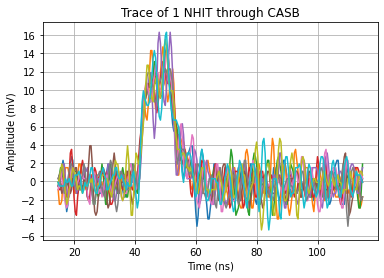

In [7]:
def plot_waveform(df,n):
    try:
        # Plot the data
        plt.plot(df["Time"]*1e9, 1e3*(df["CH1"]-0.0895), linestyle='-', label=file_path)
        plt.xlabel("Time (ns)")
        plt.ylabel("Amplitude (mV)")
        plt.title("Trace of 1 NHIT through CASB")
        plt.grid(True)
        plt.yticks(np.arange(-6,18,2))
        #plt.xlim(20,40)
        
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")

# Loop through files from C1--Trace--0000.txt to C1--Trace--0030.txt
n=1
for i in range(10):
    file_path = f'../casb2/singles/ch12/tek{i:04d}ALL.csv'  # Format number to 4 digits with leading zeros
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    plot_waveform(df_casb,i)

In [9]:
def getPeakIndex(data,ped,thresh):
    peak=0
    peak_i=0
    thresh_i=0
    start=False
    neg_counter=0
    for i in range(len(data)):
        # start once we cross threshold
        if (data[i]-ped)>thresh and start==False:
            #print(f"Crossed threshold of {thresh} at {data[i]-ped}")
            start=True
            thresh_i=i
        if start==True and data[i]>peak:
            #print(f"Going up! At {data[i]-ped}")
            peak=data[i]
            peak_i=i
        elif start==True and data[i]<peak:
            #print(f"Going down! At {data[i]-ped}")
            neg_counter+=1
        # Previously crossed threshold and are now regressing
        if start==True and neg_counter>4:
            #print(f"Gone down {neg_counter} times! Stopping")
            break
    #print(f"Found peak at {data[peak_i]-ped}")
    return peak_i,thresh_i

def getPedestal(data,s,e):
    avg=0
    start=int(len(data)*s)
    end=int(len(data)*e)
    for i in range(start,end):
        avg+=data[i]
    return avg/(end-start)

def getLowCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    # Cound down from starting index until we go below thresh
    for i in range(start_i,-1,-1):
        #print(i)
        if data[i]<thresh:
            under=i
            over=i+1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getHighCrossingTime(time,data,thresh,start_i):
    over=0 # first index where data crosses threshold
    under=0 # index before crossing threshold 
    for i in range(start_i,len(data)):
        #print(i)
        if data[i]>thresh:
            over=i
            under=i-1
            break
    #print(under,over)
    m=(data[over]-data[under])/(time[over]-time[under])
    cross_time=time[under]+((thresh-data[under])/m)
    #print(time[under]*1e9,round(cross_time*1e9,2),time[over]*1e9)
    return cross_time

def getRiseTime(time,data,threshLowPC,threshHighPC,thresh):
    ped=getPedestal(data,0.5,1)
    peak_i,thresh_i=getPeakIndex(data,ped,thresh)
    amp=data[peak_i]-ped
    print("-------")
    #print(f"Pedestal {ped*1e3}")
    #print(f"Peak {data[peak_i]*1e3} at {time[peak_i]*1e9}")
    print(f"Amplitude {amp*1e3}")
    #print(f"Starting at time {time[thresh_i]*1e9}")
    threshLow=ped+amp*threshLowPC/100
    threshHigh=ped+amp*threshHighPC/100
    tLow=getLowCrossingTime(time,data,threshLow,thresh_i)*1e9
    tHigh=getHighCrossingTime(time,data,threshHigh,thresh_i)*1e9
    print(f"Crossed low of {(threshLow-ped)*1e3} at {tLow}")
    print(f"Crossed high of {(threshHigh-ped)*1e3} at {tHigh}")
    rt=tHigh-tLow
    return round(rt,3)

def plot_waveform(df,n,rt):
    try:
        # Plot the data
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

        ped1=getPedestal(df["CH3"],0.5,1)
        ax1.plot(df["Time"]*1e9, 1e3*(df["CH3"]-ped1), color='green', label=file_path)
        ax1.set_xlabel("Time (ns)")
        ax1.set_ylabel("Amplitude (mV)")
        ax1.set_title("HVSS output NHIT into CASB")

        ped2=getPedestal(df["CH1"],0.5,1)
        ax2.plot(df["Time"]*1e9, 1e3*(df["CH1"]-ped2), color='red', label=file_path)
        ax2.set_xlabel("Time (ns)")
        ax2.set_ylabel("Amplitude (mV)")
        ax2.set_title(f"CASB analog monitor (rt={rt} ns)")
        ax2.grid()
        #ax2.set_xlim(30,70)
        
        ax3.plot(df["Time"]*1e9, (df["CH2"]), color='blue', label=file_path)
        ax3.set_ylabel("Amplitude (V)")
        ax3.set_title("CASB output ECL trigger")
        ax3.grid()
     
    except Exception as e:
        print(f"An error occurred while processing {file_path}: {e}")



-------
Amplitude 11.917460317460355
Crossed low of 2.3834920634920738 at 41.84433862433862
Crossed high of 9.53396825396828 at 44.50825396825397
2.664
../casb2/singles/ch1/tek0000ALL.csv
-------
Amplitude 13.679365079365096
Crossed low of 2.735873015873025 at 41.542751322751315
Crossed high of 10.943492063492071 at 44.7128253968254
3.17
../casb2/singles/ch1/tek0001ALL.csv
-------
Amplitude 11.228571428571406
Crossed low of 2.2457142857142816 at 40.50342857142857
Crossed high of 8.982857142857126 at 43.37085714285715
2.867
../casb2/singles/ch1/tek0002ALL.csv
-------
Amplitude 11.596825396825396
Crossed low of 2.319365079365074 at 41.40450793650793
Crossed high of 9.277460317460323 at 43.793544973544975
2.389
../casb2/singles/ch1/tek0003ALL.csv
-------
Amplitude 12.301587301587313
Crossed low of 2.4603174603174685 at 41.63696145124716
Crossed high of 9.841269841269845 at 43.86984126984127
2.233
../casb2/singles/ch1/tek0004ALL.csv
-------
Amplitude 11.93333333333331
Crossed low of 2.3866

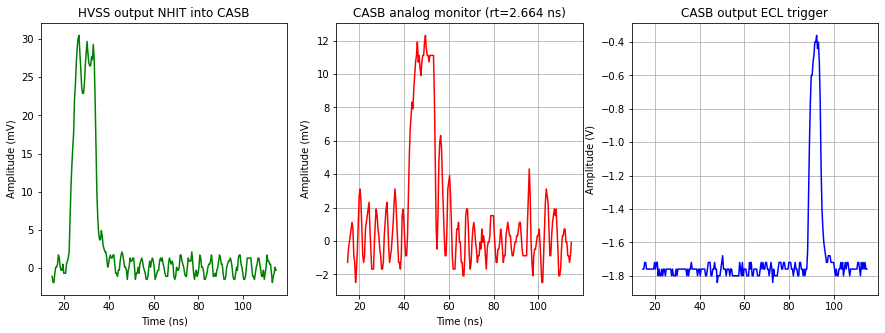

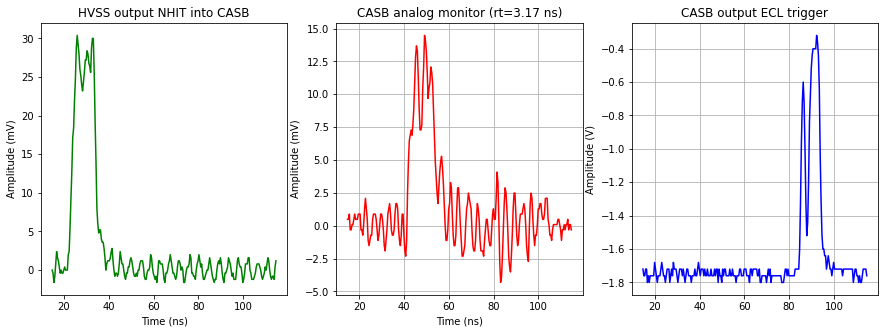

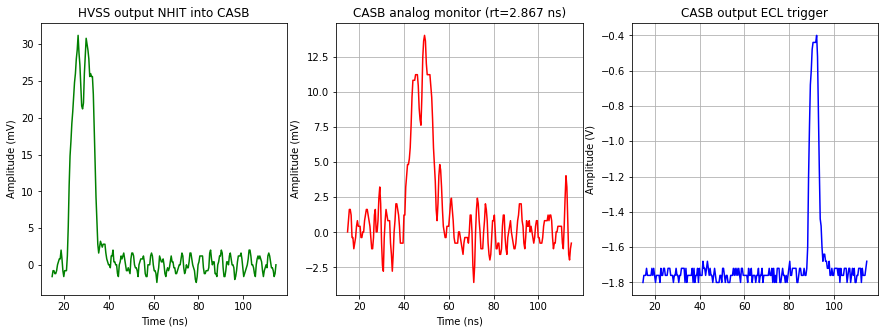

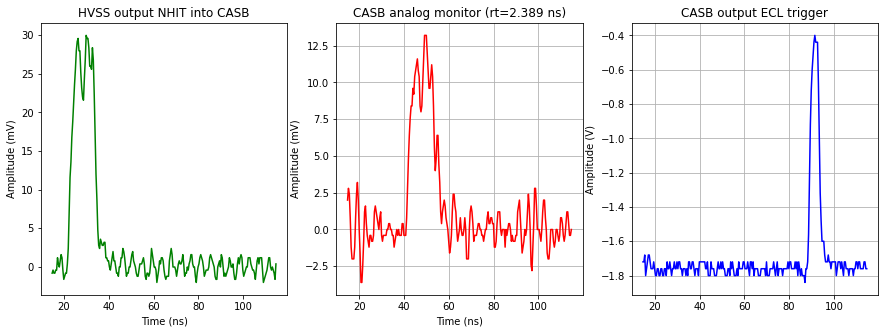

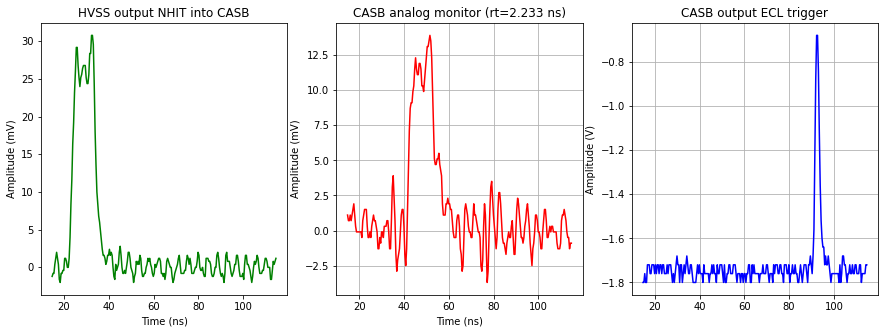

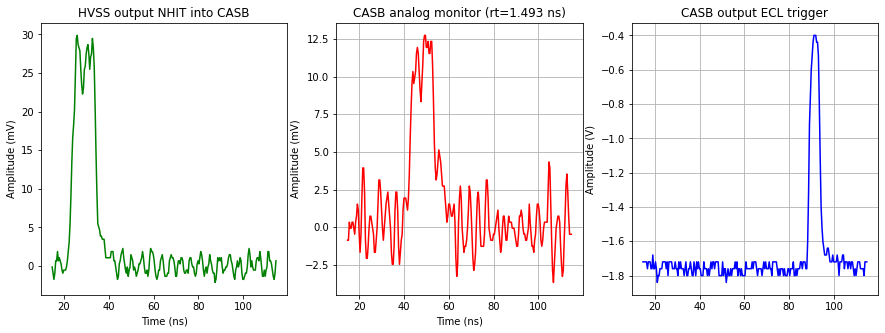

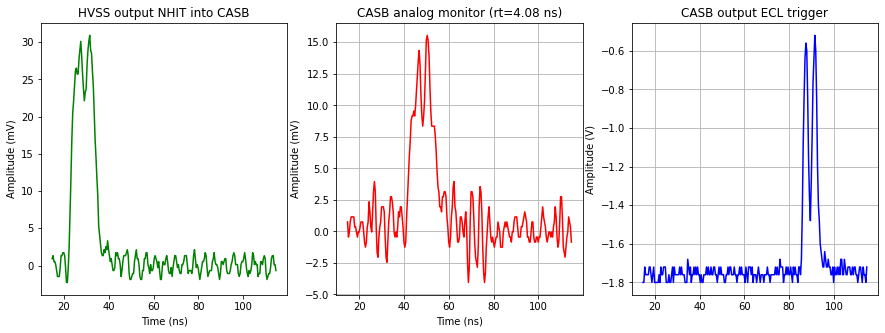

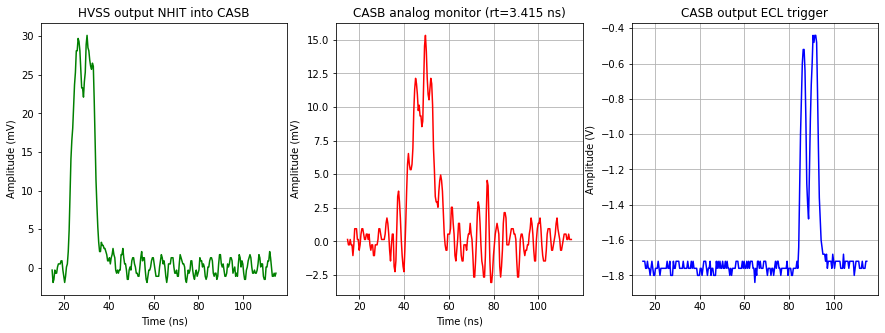

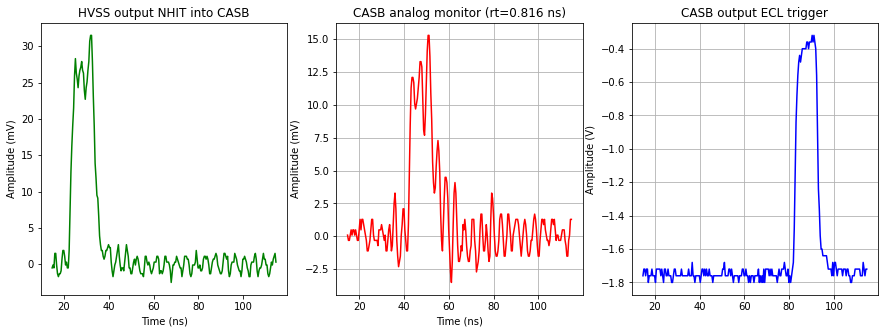

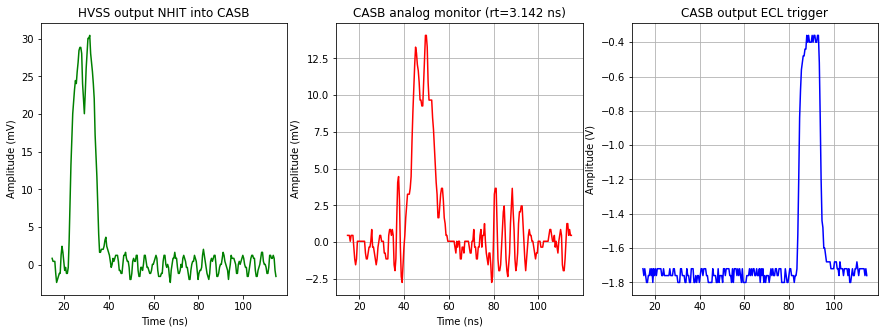

In [10]:

# Loop through files
n=10
for i in range(n):
    file_path = f'../casb2/singles/ch1/tek{i:04d}ALL.csv'  # Format number to 4 digits with leading zeros
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],20,80,0.005)
    print(rt)
    print(file_path)
    plot_waveform(df_casb,n,rt)


In [91]:

start,end=20,80

casb1=[]
for i in range(30):
    file_path = f'../casb1/singles/C1--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude'],start,end,0.005)
    print(rt)
    casb1.append(rt)

casb2=[]
for i in range(10):
    file_path= f'../casb2/singles/ch1/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    file_path= f'../casb2/singles/ch9/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    file_path= f'ch16/tek{i:04d}ALL.csv'
    df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    rt=getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005)
    print(rt)
    casb2.append(rt)
    print(file_path)
    # file_path= f'ch12/tek{i:04d}ALL.csv'
    # df_casb = pd.read_csv(file_path, skiprows=21, names=["Time", "CH1", "CH2", "CH3"])
    # casb2.append(getRiseTime(df_casb["Time"],df_casb["CH1"],start,end,0.005))
    

mtca=[]    
for i in range(35):
    file_path = f'../mtca/singles/C4--Trace--{i:05d}.txt'  # Format number to 4 digits with leading zeros
    df = pd.read_csv(file_path, skiprows=5, names=["Time", "Amplitude"])
    rt=getRiseTime(df['Time'],df['Amplitude']*-1,start,end,0.02)
    print(rt)
    mtca.append(rt)


-------
Amplitude 8.432002195608703
Crossed low of 1.6864004391217435 at 16.802609677979767
Crossed high of 6.74560175648696 at 18.19181930968896
1.389
-------
Amplitude 9.11664431137725
Crossed low of 1.8233288622754444 at 17.04212899321732
Crossed high of 7.293315449101792 at 18.71841779583162
1.676
-------
Amplitude 11.911797005988031
Crossed low of 2.3823594011976033 at 17.450759231363055
Crossed high of 9.529437604790427 at 19.651705193557653
2.201
-------
Amplitude 10.909636127744662
Crossed low of 2.181927225548927 at 17.69223464468909
Crossed high of 8.727708902195722 at 19.40577898630511
1.714
-------
Amplitude 11.76040758483031
Crossed low of 2.3520815169660594 at 17.00066439465121
Crossed high of 9.40832606786425 at 20.30779910766702
3.307
-------
Amplitude 11.45356526946112
Crossed low of 2.290713053892224 at 17.47730585338198
Crossed high of 9.162852215568895 at 20.17278899442493
2.695
-------
Amplitude 12.308179640718592
Crossed low of 2.4616359281437186 at 17.59186183790

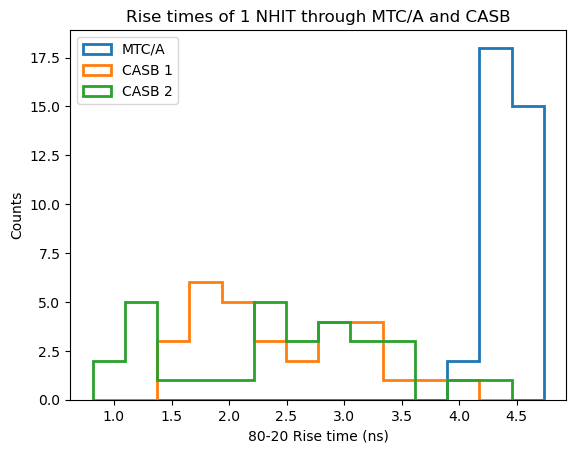

In [92]:
import numpy as np
import matplotlib.pyplot as plt

# Determine shared bins
all_data = mtca + casb1 + casb2
bins = np.linspace(min(all_data), max(all_data), 15)

# Plot histograms with shared bins
plt.hist(mtca, bins=bins, density=False, histtype='step', label='MTC/A', linewidth=2)
plt.hist(casb1, bins=bins, density=False, histtype='step', label='CASB 1', linewidth=2)
plt.hist(casb2, bins=bins, density=False, histtype='step', label='CASB 2', linewidth=2)


# Add labels, legend, and title
plt.xlabel(f'{end}-{start} Rise time (ns)')
plt.ylabel('Counts')
plt.title('Rise times of 1 NHIT through MTC/A and CASB')
#plt.yticks(np.arange(0,40,5))
plt.legend()

# Display the plot
plt.show()


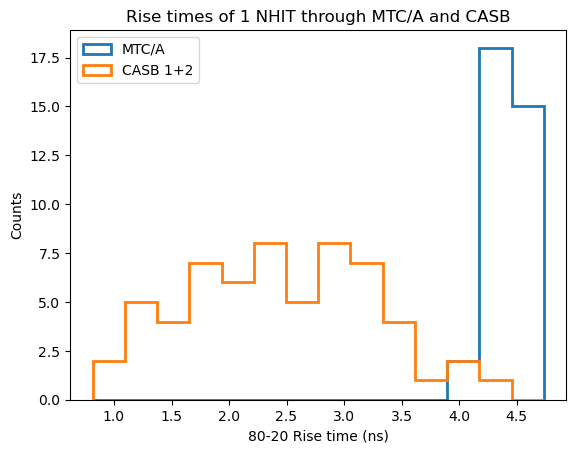

In [93]:
import numpy as np
import matplotlib.pyplot as plt

# Determine shared bins
all_data = mtca + casb1 + casb2
bins = np.linspace(min(all_data), max(all_data), 15)

# Plot histograms with shared bins
plt.hist(mtca, bins=bins, density=False, histtype='step', label='MTC/A', linewidth=2)
plt.hist(casb1+casb2, bins=bins, density=False, histtype='step', label='CASB 1+2', linewidth=2)
#plt.hist(casb2, bins=bins, density=False, histtype='step', label='CASB 2', linewidth=2)


# Add labels, legend, and title
plt.xlabel(f'{end}-{start} Rise time (ns)')
plt.ylabel('Counts')
plt.title('Rise times of 1 NHIT through MTC/A and CASB')
#plt.yticks(np.arange(0,40,5))
plt.legend()

# Display the plot
plt.show()
